<a href="https://colab.research.google.com/github/edegp/katakana/blob/main/VGG(4)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
ROOT_PATH = '/content/drive/My Drive/Colab Notebooks/'
sys.path.append(ROOT_PATH)
import common

Mounted at /content/drive


In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from common.loss import mean_squared_error
from common.multi_layer_net_extend import MultiLayerNetExtend
from collections import OrderedDict
from common.layers import Convolution,MaxPooling, ReLU, Affine, LogSoftmaxWithLoss,BatchNormalization,Dropout
from common.optimizer import RMSProp,Adadelta,Adam
from common.pruning import *

In [4]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.5 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 209 kB 57.5 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 112 kB 58.2 MB/s 
     |████████████████████████████████| 147 kB 48.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=45d83f989313fa90c4e0366a274226678a49463a0e418de5b0e7a6e73fc5c7cf
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [5]:
def he(n):
    """
    Heの初期値を利用するための関数
    返り値は、見かけの標準偏差
    """    
    return np.sqrt(2/n)

In [6]:
def xavier(n1, n2):
    """
    Xavierの初期値を利用するための関数
    返り値は、見かけの標準偏差
    """
    return np.sqrt(2/(n1+n2))   

In [7]:
def images_gen(data,label,datagen,num):
    datas = [];
    labels = [];
    data = data.transpose(0,2,3,1)
    for data,label in zip(data,label):
        data = data.reshape((1,) + data.shape)
        batch_list=[]
        i = 0
        g = datagen.flow(data, batch_size=1)
        for i in range(num):
          batchs = g.next()
          batchs=batchs.reshape((28, 28, 1)).transpose(2,0,1)
          datas.append(batchs)
          labels.append(label)
    train_data=np.array(datas)
    train_label=np.array(labels)
    for l in [train_data, train_label]:
      np.random.seed(1)
      np.random.shuffle(l) 
    return train_data,train_label            


In [8]:
def create_img(X_train,y_train,num):
      # ImageDataGeneratorのオブジェクト生成
    datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.3,
            shear_range=15
            )
    X_train,y_train=images_gen(X_train,y_train,datagen,num)
    print(X_train.shape)
    print(y_train.shape)

    x = X_train
    t = y_train

    x = x.reshape(-1,1,28,28) # 配列形式の変形

    return x,t


In [9]:
class GlobalAveragePooling2D:
    def __init__(self, GlobalPooling2D='channels_last'):
        self.data_format = GlobalPooling2D

    def forward(self, x):
        self.x = x
        out = x.mean(axis= (2, 3))
        return out

    def backward(self, dout):
        xs = self.x.shape
        n = xs[2] * xs[3]
        dx = np.empty((xs))
        for i in range(xs[0]):
          dx[i]=np.tile(dout[i] / n,(n)).reshape([xs[1],xs[2],xs[3]],order='F')
        return dx

In [10]:
data = np.load("drive/My Drive/Colab Notebooks/test/train_data.npy")  # パスは適宜変更すること
label = np.load("drive/My Drive/Colab Notebooks/test/train_label.npy")  # パスは適宜変更すること
# 正規化
data = (data - data.min()) / data.max()
data = data.astype('float32')
X_train, X_test,y_train,y_test = train_test_split(data,label, test_size=0.15, random_state=12)

In [11]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 param=[[32,3,0,1],[64,3,0,1]],
                 pool_param=[[2,0,2],[2,0,2]],
                output_size=15, 
                 weight_decay_lambda=1e-5,
                 ):
        self.weight_decay_lambda = weight_decay_lambda

        self.params = {}
        #一層目
        self.params['W1'] = he(input_dim[0]) * np.random.randn(param[0][0], input_dim[0], param[0][1], param[0][1]) 
        self.params['b1'] = np.zeros(param[0][0])
        self.params['gamma2'] = np.ones(param[0][0])
        self.params['beta2'] = np.zeros(param[0][0])

        # 二層目
        self.params['W2'] = he(param[0][0]) * np.random.randn(param[0][0], param[0][0], param[0][1], param[0][1]) 
        self.params['b2'] = np.zeros(param[0][0])
        
        #三層目
        self.params['W3'] = he(param[0][0])  * np.random.randn(param[1][0], param[0][0], param[1][1], param[1][1]) 
        self.params['b3'] = np.zeros(param[1][0])
        
        self.params['W4'] = he(param[1][0]) * np.random.randn(param[1][0], param[1][0], param[1][1], param[1][1])
        self.params['b4'] = np.zeros(param[1][0])
        self.params['gamma4'] = np.ones(param[1][0])
        self.params['beta4'] = np.zeros(param[1][0])

        # アフィン
        self.params['W6'] = xavier(param[1][0], output_size) *  np.random.randn(param[1][0], output_size)
        self.params['b6'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],param[0][3], param[0][2]) 
        self.layers['batch2'] = BatchNormalization(self.params['gamma2'],self.params['beta2'])
        self.layers['ReLU1'] = ReLU()
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'],param[0][3], param[0][2]) 
        self.layers['ReLU2'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_param[0][0], pool_w=pool_param[0][0], stride=pool_param[0][2], pad=pool_param[0][1])

        self.layers['Conv3'] = Convolution(self.params['W3'], self.params['b3'],param[1][3], param[1][2]) 
        self.layers['ReLU3'] = ReLU()
        self.layers['Conv4'] = Convolution(self.params['W4'], self.params['b4'],param[1][3], param[1][2]) 
        self.layers['batch4'] = BatchNormalization(self.params['gamma4'],self.params['beta4'])
        self.layers['ReLU4'] = ReLU()
        self.layers['Pool2'] = MaxPooling(pool_h=pool_param[1][0], pool_w=pool_param[1][0], stride=pool_param[1][2], pad=pool_param[1][1])
        self.layers['GAP'] = GlobalAveragePooling2D()
        self.layers['Affine2'] = Affine(self.params['W6'], self.params['b6'])
        self.last_layer = LogSoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        lmd = self.weight_decay_lambda
        
        weight_decay = 0
        weights = ['W1','W2','W3','W4','W6']
        for w in weights:
            W = self.params[w]
            weight_decay += 0.5 * lmd * np.sum(W**2)

        return self.last_layer.forward(y, t)+ weight_decay

    def accuracy(self, x, t, batch_size=25):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        lmd = self.weight_decay_lambda
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW + lmd * self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW + lmd * self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['gamma2'], grads['beta2'] = self.layers['batch2'].dgamma, self.layers['batch2'].dbeta
        grads['W3'], grads['b3'] = self.layers['Conv3'].dW + lmd * self.layers['Conv3'].dW, self.layers['Conv3'].db
        grads['W4'], grads['b4'] = self.layers['Conv4'].dW + lmd * self.layers['Conv4'].dW, self.layers['Conv4'].db
        grads['gamma4'], grads['beta4'] = self.layers['batch4'].dgamma, self.layers['batch4'].dbeta
        grads['W6'], grads['b6'] = self.layers['Affine2'].dW + lmd * self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    def condition(self,num,x,t,X_test,y_test):
        loss=self.loss(x[:num,:], t[:num,:])
        val_loss=self.loss(X_test[:num,:], y_test[:num,:])
        acc=self.accuracy(x[:num,:], t[:num,:],num//10)
        val_acc=self.accuracy(X_test[:num,:], y_test[:num,:],num//10)
        return loss,val_loss,acc,val_acc
    def fit(self,model,x,t,epochs,batch_size,test,test_labels):
        train_loss = []
        test_loss = []
        train_accuracy = []
        test_accuracy = []
        xsize = x.shape[0]
        iter_num = np.ceil(xsize / batch_size).astype(np.int64)
        for epoch in range(epochs):
          print("epoch=%s"%epoch, end=': ')
          idx = np.arange(xsize)
          np.random.shuffle(idx)
          optimizer = Adadelta()
          pbar=tqdm(range(iter_num))
          for it in pbar:
            mask = idx[batch_size*it : batch_size*(it+1)]
            # ミニバッチの生成
            x_train = x[mask]
            t_train = t[mask]
            grads = self.gradient(x_train, t_train)
            optimizer.update(self.params, grads)
            if it % 100 == 0:
              condition = self.condition(30,x,t,X_train,y_train)
            elif it == len(pbar)-1:
              condition = self.condition(300,x,t,X_train,y_train)
              train_loss.append(condition[0])
              test_loss.append(condition[1])
              train_accuracy.append(condition[2])
              test_accuracy.append(condition[3])
            pbar.set_postfix(OrderedDict(loss=condition[0],val_loss=condition[1], acc=condition[2],val_acc=condition[3]))
            if epoch==50:
              pruning_rate = 0.2
              masks = create_model_mask(self.params,pruning_rate)
              self.weight_decay_lambda=1e-7
            if 50 < epoch < 55: prune_weight(self.params, masks)
            if epoch == 80:
              pruning_rate = 0.4
              masks = create_model_mask(self.params,pruning_rate)
              self.weight_decay_lambda=0
            if 80 < epoch < 85: prune_weight(self.params, masks)
          history = {'val_loss': test_loss,
                    'val_acc': test_accuracy,
                    'loss': train_loss,
                    'acc': train_accuracy}

          if epoch % 10 == 0 and not epoch == 0:           
            df_log = pd.DataFrame(history)
            df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
            plt.ylim([0,1.05])
            plt.ylabel("Accuracy or loss")
            plt.xlabel("epochs")
            plt.show()

        return history

In [12]:
def build_model(fs,wdl):
    model = SimpleConvNet(input_dim=(1, 28, 28), 
                        param=[[fs,3,0,1],[fs*2,3,0,1]],
                        pool_param=[[2,0,2],[2,0,2]],
                        output_size=15,
                        weight_decay_lambda=wdl
                        )
    return model

[I 2022-08-23 12:20:34,938] A new study created in memory with name: no-name-8c7ec7ee-f189-44b6-b558-1d3189fdd0b4


8
32
7.894265773019396e-06
(5100, 1, 28, 28)
(5100, 15)
epoch=0: 

100%|██████████| 638/638 [01:36<00:00,  6.58it/s, loss=1.39, val_loss=0.815, acc=0.53, val_acc=0.797]


epoch=1: 

100%|██████████| 638/638 [01:27<00:00,  7.26it/s, loss=1.01, val_loss=0.478, acc=0.653, val_acc=0.857]


epoch=2: 

100%|██████████| 638/638 [01:26<00:00,  7.42it/s, loss=0.836, val_loss=0.369, acc=0.69, val_acc=0.91]


epoch=3: 

100%|██████████| 638/638 [01:24<00:00,  7.53it/s, loss=0.667, val_loss=0.238, acc=0.743, val_acc=0.95]


epoch=4: 

100%|██████████| 638/638 [01:27<00:00,  7.33it/s, loss=0.609, val_loss=0.207, acc=0.777, val_acc=0.943]


epoch=5: 

100%|██████████| 638/638 [01:25<00:00,  7.45it/s, loss=0.596, val_loss=0.198, acc=0.793, val_acc=0.953]


epoch=6: 

100%|██████████| 638/638 [01:25<00:00,  7.43it/s, loss=0.466, val_loss=0.191, acc=0.833, val_acc=0.943]


epoch=7: 

100%|██████████| 638/638 [01:27<00:00,  7.33it/s, loss=0.469, val_loss=0.174, acc=0.837, val_acc=0.963]


epoch=8: 

100%|██████████| 638/638 [01:27<00:00,  7.28it/s, loss=0.428, val_loss=0.171, acc=0.857, val_acc=0.943]


epoch=9: 

100%|██████████| 638/638 [01:26<00:00,  7.35it/s, loss=0.358, val_loss=0.131, acc=0.887, val_acc=0.957]


epoch=10: 

100%|██████████| 638/638 [01:26<00:00,  7.41it/s, loss=0.362, val_loss=0.15, acc=0.873, val_acc=0.95]


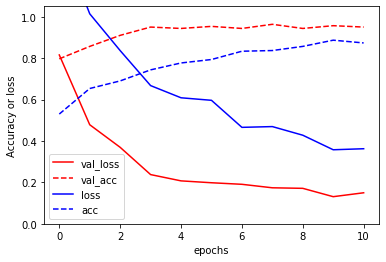

epoch=11: 

100%|██████████| 638/638 [01:26<00:00,  7.34it/s, loss=0.271, val_loss=0.129, acc=0.897, val_acc=0.957]


epoch=12: 

100%|██████████| 638/638 [01:26<00:00,  7.34it/s, loss=0.26, val_loss=0.131, acc=0.91, val_acc=0.947]


epoch=13: 

100%|██████████| 638/638 [01:26<00:00,  7.39it/s, loss=0.226, val_loss=0.121, acc=0.923, val_acc=0.97]


epoch=14: 

100%|██████████| 638/638 [01:26<00:00,  7.39it/s, loss=0.227, val_loss=0.119, acc=0.913, val_acc=0.97]


epoch=15: 

100%|██████████| 638/638 [01:27<00:00,  7.30it/s, loss=0.222, val_loss=0.134, acc=0.91, val_acc=0.963]


epoch=16: 

100%|██████████| 638/638 [01:26<00:00,  7.41it/s, loss=0.205, val_loss=0.131, acc=0.93, val_acc=0.967]


epoch=17: 

100%|██████████| 638/638 [01:26<00:00,  7.39it/s, loss=0.163, val_loss=0.116, acc=0.957, val_acc=0.973]


epoch=18: 

100%|██████████| 638/638 [01:25<00:00,  7.44it/s, loss=0.156, val_loss=0.138, acc=0.943, val_acc=0.957]


epoch=19: 

100%|██████████| 638/638 [01:26<00:00,  7.37it/s, loss=0.17, val_loss=0.107, acc=0.95, val_acc=0.967]


epoch=20: 

100%|██████████| 638/638 [01:26<00:00,  7.40it/s, loss=0.169, val_loss=0.122, acc=0.953, val_acc=0.97]


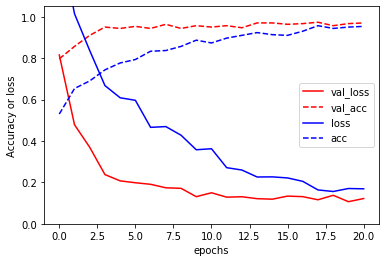

epoch=21: 

100%|██████████| 638/638 [01:26<00:00,  7.36it/s, loss=0.132, val_loss=0.126, acc=0.957, val_acc=0.97]


epoch=22: 

100%|██████████| 638/638 [01:25<00:00,  7.49it/s, loss=0.11, val_loss=0.116, acc=0.977, val_acc=0.973]


epoch=23: 

100%|██████████| 638/638 [01:26<00:00,  7.35it/s, loss=0.118, val_loss=0.147, acc=0.967, val_acc=0.96]


epoch=24: 

100%|██████████| 638/638 [01:29<00:00,  7.17it/s, loss=0.147, val_loss=0.132, acc=0.957, val_acc=0.967]


epoch=25: 

100%|██████████| 638/638 [01:32<00:00,  6.87it/s, loss=0.109, val_loss=0.131, acc=0.973, val_acc=0.963]


epoch=26: 

100%|██████████| 638/638 [01:31<00:00,  6.94it/s, loss=0.121, val_loss=0.136, acc=0.97, val_acc=0.96]


epoch=27: 

100%|██████████| 638/638 [01:34<00:00,  6.78it/s, loss=0.116, val_loss=0.188, acc=0.973, val_acc=0.94]


epoch=28: 

100%|██████████| 638/638 [01:32<00:00,  6.93it/s, loss=0.0966, val_loss=0.145, acc=0.99, val_acc=0.967]


epoch=29: 

100%|██████████| 638/638 [01:31<00:00,  6.95it/s, loss=0.0775, val_loss=0.137, acc=0.987, val_acc=0.957]


accuracy=0.9849019607843137


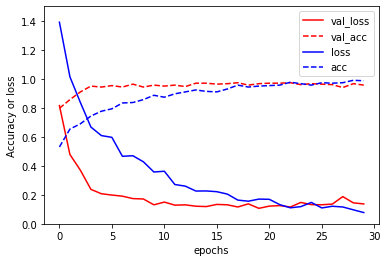

[I 2022-08-23 13:05:02,901] Trial 0 finished with value: 0.07748191759823211 and parameters: {'bs': 8, 'fs': 32, 'wdl': 7.894265773019396e-06}. Best is trial 0 with value: 0.07748191759823211.


24
16
1.8157573644888738e-05
(5100, 1, 28, 28)
(5100, 15)
epoch=0: 

100%|██████████| 213/213 [00:41<00:00,  5.09it/s, loss=2.06, val_loss=1.68, acc=0.363, val_acc=0.58]


epoch=1: 

100%|██████████| 213/213 [00:41<00:00,  5.12it/s, loss=1.76, val_loss=1.19, acc=0.44, val_acc=0.777]


epoch=2: 

100%|██████████| 213/213 [00:44<00:00,  4.82it/s, loss=1.49, val_loss=0.871, acc=0.533, val_acc=0.827]


epoch=3: 

100%|██████████| 213/213 [00:42<00:00,  5.05it/s, loss=1.28, val_loss=0.706, acc=0.597, val_acc=0.843]


epoch=4: 

100%|██████████| 213/213 [00:41<00:00,  5.11it/s, loss=1.14, val_loss=0.557, acc=0.633, val_acc=0.883]


epoch=5: 

100%|██████████| 213/213 [00:41<00:00,  5.09it/s, loss=1.03, val_loss=0.479, acc=0.68, val_acc=0.887]


epoch=6: 

100%|██████████| 213/213 [00:41<00:00,  5.11it/s, loss=0.905, val_loss=0.396, acc=0.747, val_acc=0.893]


epoch=7: 

100%|██████████| 213/213 [00:41<00:00,  5.08it/s, loss=0.811, val_loss=0.388, acc=0.74, val_acc=0.893]


epoch=8: 

100%|██████████| 213/213 [00:41<00:00,  5.08it/s, loss=0.771, val_loss=0.334, acc=0.777, val_acc=0.91]


epoch=9: 

100%|██████████| 213/213 [00:41<00:00,  5.16it/s, loss=0.7, val_loss=0.297, acc=0.79, val_acc=0.927]


epoch=10: 

100%|██████████| 213/213 [00:40<00:00,  5.28it/s, loss=0.668, val_loss=0.296, acc=0.777, val_acc=0.92]


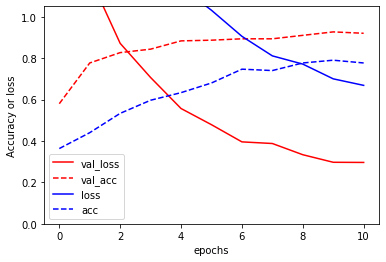

epoch=11: 

100%|██████████| 213/213 [00:41<00:00,  5.13it/s, loss=0.654, val_loss=0.277, acc=0.793, val_acc=0.907]


epoch=12: 

100%|██████████| 213/213 [00:41<00:00,  5.15it/s, loss=0.596, val_loss=0.248, acc=0.787, val_acc=0.933]


epoch=13: 

100%|██████████| 213/213 [00:41<00:00,  5.18it/s, loss=0.572, val_loss=0.27, acc=0.817, val_acc=0.91]


epoch=14: 

100%|██████████| 213/213 [00:41<00:00,  5.14it/s, loss=0.511, val_loss=0.256, acc=0.843, val_acc=0.927]


epoch=15: 

100%|██████████| 213/213 [00:40<00:00,  5.21it/s, loss=0.47, val_loss=0.238, acc=0.843, val_acc=0.923]


epoch=16: 

100%|██████████| 213/213 [00:40<00:00,  5.22it/s, loss=0.5, val_loss=0.246, acc=0.82, val_acc=0.917]


epoch=17: 

100%|██████████| 213/213 [00:41<00:00,  5.19it/s, loss=0.412, val_loss=0.199, acc=0.86, val_acc=0.943]


epoch=18: 

100%|██████████| 213/213 [00:41<00:00,  5.19it/s, loss=0.43, val_loss=0.221, acc=0.853, val_acc=0.927]


epoch=19: 

100%|██████████| 213/213 [00:41<00:00,  5.18it/s, loss=0.419, val_loss=0.217, acc=0.857, val_acc=0.94]


epoch=20: 

100%|██████████| 213/213 [00:41<00:00,  5.13it/s, loss=0.376, val_loss=0.203, acc=0.857, val_acc=0.933]


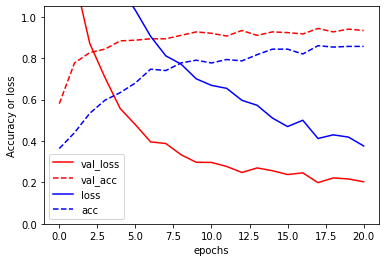

epoch=21: 

100%|██████████| 213/213 [00:41<00:00,  5.19it/s, loss=0.328, val_loss=0.188, acc=0.87, val_acc=0.953]


epoch=22: 

100%|██████████| 213/213 [00:41<00:00,  5.15it/s, loss=0.346, val_loss=0.189, acc=0.87, val_acc=0.94]


epoch=23: 

100%|██████████| 213/213 [00:40<00:00,  5.21it/s, loss=0.333, val_loss=0.17, acc=0.893, val_acc=0.953]


epoch=24: 

100%|██████████| 213/213 [00:41<00:00,  5.16it/s, loss=0.315, val_loss=0.195, acc=0.887, val_acc=0.93]


epoch=25: 

100%|██████████| 213/213 [00:41<00:00,  5.13it/s, loss=0.292, val_loss=0.174, acc=0.88, val_acc=0.95]


epoch=26: 

100%|██████████| 213/213 [00:41<00:00,  5.10it/s, loss=0.294, val_loss=0.169, acc=0.893, val_acc=0.947]


epoch=27: 

100%|██████████| 213/213 [00:41<00:00,  5.17it/s, loss=0.254, val_loss=0.178, acc=0.913, val_acc=0.943]


epoch=28: 

100%|██████████| 213/213 [00:41<00:00,  5.16it/s, loss=0.249, val_loss=0.175, acc=0.907, val_acc=0.943]


epoch=29: 

100%|██████████| 213/213 [00:41<00:00,  5.18it/s, loss=0.254, val_loss=0.158, acc=0.897, val_acc=0.937]


accuracy=0.8970588235294118


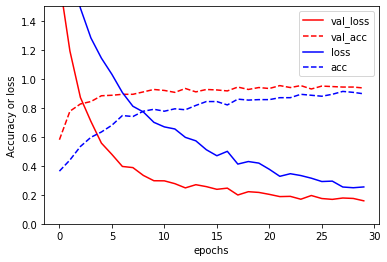

[I 2022-08-23 13:26:04,288] Trial 1 finished with value: 0.2542671336348184 and parameters: {'bs': 24, 'fs': 16, 'wdl': 1.8157573644888738e-05}. Best is trial 0 with value: 0.07748191759823211.


8
32
8.755821953031085e-06
(5100, 1, 28, 28)
(5100, 15)
epoch=0: 

100%|██████████| 638/638 [01:34<00:00,  6.76it/s, loss=1.29, val_loss=0.829, acc=0.583, val_acc=0.77]


epoch=1: 

100%|██████████| 638/638 [01:37<00:00,  6.57it/s, loss=0.869, val_loss=0.422, acc=0.72, val_acc=0.9]


epoch=2: 

100%|██████████| 638/638 [01:35<00:00,  6.69it/s, loss=0.672, val_loss=0.312, acc=0.757, val_acc=0.913]


epoch=3: 

100%|██████████| 638/638 [01:35<00:00,  6.66it/s, loss=0.57, val_loss=0.265, acc=0.79, val_acc=0.917]


epoch=4: 

100%|██████████| 638/638 [01:35<00:00,  6.70it/s, loss=0.45, val_loss=0.193, acc=0.857, val_acc=0.963]


epoch=5: 

100%|██████████| 638/638 [01:35<00:00,  6.69it/s, loss=0.434, val_loss=0.174, acc=0.833, val_acc=0.94]


epoch=6: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.419, val_loss=0.164, acc=0.84, val_acc=0.95]


epoch=7: 

100%|██████████| 638/638 [01:35<00:00,  6.66it/s, loss=0.347, val_loss=0.145, acc=0.887, val_acc=0.96]


epoch=8: 

100%|██████████| 638/638 [01:35<00:00,  6.70it/s, loss=0.313, val_loss=0.162, acc=0.887, val_acc=0.96]


epoch=9: 

100%|██████████| 638/638 [01:35<00:00,  6.65it/s, loss=0.318, val_loss=0.151, acc=0.89, val_acc=0.947]


epoch=10: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.27, val_loss=0.128, acc=0.91, val_acc=0.96]


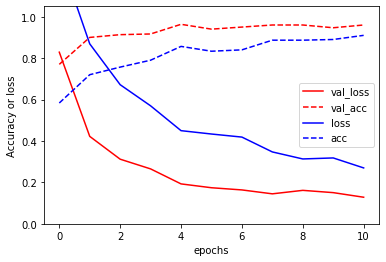

epoch=11: 

100%|██████████| 638/638 [01:35<00:00,  6.70it/s, loss=0.259, val_loss=0.11, acc=0.91, val_acc=0.977]


epoch=12: 

100%|██████████| 638/638 [01:34<00:00,  6.74it/s, loss=0.243, val_loss=0.116, acc=0.897, val_acc=0.97]


epoch=13: 

100%|██████████| 638/638 [01:34<00:00,  6.74it/s, loss=0.217, val_loss=0.123, acc=0.923, val_acc=0.963]


epoch=14: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.23, val_loss=0.101, acc=0.92, val_acc=0.977]


epoch=15: 

100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.186, val_loss=0.135, acc=0.937, val_acc=0.967]


epoch=16: 

100%|██████████| 638/638 [01:36<00:00,  6.63it/s, loss=0.207, val_loss=0.129, acc=0.92, val_acc=0.957]


epoch=17: 

100%|██████████| 638/638 [01:36<00:00,  6.64it/s, loss=0.153, val_loss=0.106, acc=0.953, val_acc=0.98]


epoch=18: 

100%|██████████| 638/638 [01:34<00:00,  6.73it/s, loss=0.188, val_loss=0.135, acc=0.937, val_acc=0.97]


epoch=19: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.135, val_loss=0.117, acc=0.957, val_acc=0.97]


epoch=20: 

100%|██████████| 638/638 [01:35<00:00,  6.66it/s, loss=0.151, val_loss=0.111, acc=0.953, val_acc=0.973]


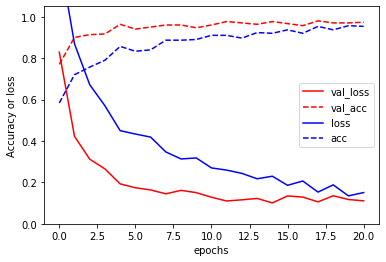

epoch=21: 

100%|██████████| 638/638 [01:35<00:00,  6.67it/s, loss=0.132, val_loss=0.115, acc=0.97, val_acc=0.97]


epoch=22: 

100%|██████████| 638/638 [01:36<00:00,  6.64it/s, loss=0.138, val_loss=0.0958, acc=0.97, val_acc=0.967]


epoch=23: 

100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.119, val_loss=0.112, acc=0.977, val_acc=0.97]


epoch=24: 

100%|██████████| 638/638 [01:36<00:00,  6.62it/s, loss=0.139, val_loss=0.111, acc=0.96, val_acc=0.973]


epoch=25: 

100%|██████████| 638/638 [01:35<00:00,  6.66it/s, loss=0.133, val_loss=0.111, acc=0.957, val_acc=0.97]


epoch=26: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.125, val_loss=0.11, acc=0.967, val_acc=0.967]


epoch=27: 

100%|██████████| 638/638 [01:36<00:00,  6.62it/s, loss=0.12, val_loss=0.138, acc=0.973, val_acc=0.967]


epoch=28: 

100%|██████████| 638/638 [01:36<00:00,  6.61it/s, loss=0.105, val_loss=0.123, acc=0.977, val_acc=0.967]


epoch=29: 

100%|██████████| 638/638 [01:36<00:00,  6.58it/s, loss=0.0981, val_loss=0.101, acc=0.983, val_acc=0.98]


accuracy=0.98


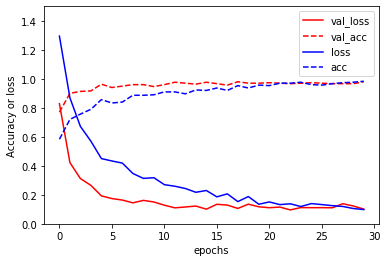

[I 2022-08-23 14:14:23,296] Trial 2 finished with value: 0.09806743491464773 and parameters: {'bs': 8, 'fs': 32, 'wdl': 8.755821953031085e-06}. Best is trial 0 with value: 0.07748191759823211.


16
16
3.871546576009465e-05
(5100, 1, 28, 28)
(5100, 15)
epoch=0: 

100%|██████████| 319/319 [00:46<00:00,  6.90it/s, loss=1.98, val_loss=1.55, acc=0.4, val_acc=0.62]


epoch=1: 

100%|██████████| 319/319 [00:46<00:00,  6.83it/s, loss=1.66, val_loss=1.05, acc=0.473, val_acc=0.79]


epoch=2: 

100%|██████████| 319/319 [00:45<00:00,  6.95it/s, loss=1.36, val_loss=0.735, acc=0.583, val_acc=0.847]


epoch=3: 

100%|██████████| 319/319 [00:45<00:00,  7.00it/s, loss=1.16, val_loss=0.573, acc=0.647, val_acc=0.873]


epoch=4: 

100%|██████████| 319/319 [00:45<00:00,  7.00it/s, loss=1.03, val_loss=0.458, acc=0.71, val_acc=0.9]


epoch=5: 

100%|██████████| 319/319 [00:46<00:00,  6.87it/s, loss=0.913, val_loss=0.413, acc=0.737, val_acc=0.883]


epoch=6: 

100%|██████████| 319/319 [00:46<00:00,  6.92it/s, loss=0.81, val_loss=0.335, acc=0.767, val_acc=0.923]


epoch=7: 

100%|██████████| 319/319 [00:45<00:00,  6.95it/s, loss=0.744, val_loss=0.353, acc=0.757, val_acc=0.897]


epoch=8: 

100%|██████████| 319/319 [00:45<00:00,  7.03it/s, loss=0.686, val_loss=0.289, acc=0.807, val_acc=0.927]


epoch=9: 

100%|██████████| 319/319 [00:45<00:00,  7.03it/s, loss=0.642, val_loss=0.265, acc=0.823, val_acc=0.943]


epoch=10: 

100%|██████████| 319/319 [00:46<00:00,  6.87it/s, loss=0.63, val_loss=0.274, acc=0.793, val_acc=0.93]


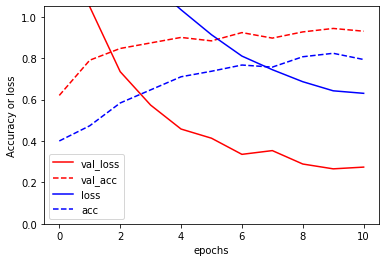

epoch=11: 

100%|██████████| 319/319 [00:45<00:00,  7.02it/s, loss=0.597, val_loss=0.259, acc=0.82, val_acc=0.927]


epoch=12: 

100%|██████████| 319/319 [00:45<00:00,  6.94it/s, loss=0.564, val_loss=0.223, acc=0.82, val_acc=0.95]


epoch=13: 

100%|██████████| 319/319 [00:45<00:00,  7.03it/s, loss=0.511, val_loss=0.237, acc=0.84, val_acc=0.933]


epoch=14: 

100%|██████████| 319/319 [00:46<00:00,  6.87it/s, loss=0.462, val_loss=0.216, acc=0.843, val_acc=0.943]


epoch=15: 

100%|██████████| 319/319 [00:45<00:00,  6.98it/s, loss=0.427, val_loss=0.222, acc=0.86, val_acc=0.943]


epoch=16: 

100%|██████████| 319/319 [00:46<00:00,  6.90it/s, loss=0.46, val_loss=0.227, acc=0.873, val_acc=0.93]


epoch=17: 

100%|██████████| 319/319 [00:45<00:00,  6.98it/s, loss=0.4, val_loss=0.188, acc=0.863, val_acc=0.947]


epoch=18: 

100%|██████████| 319/319 [00:45<00:00,  6.95it/s, loss=0.389, val_loss=0.22, acc=0.883, val_acc=0.927]


epoch=19: 

100%|██████████| 319/319 [00:46<00:00,  6.85it/s, loss=0.376, val_loss=0.215, acc=0.877, val_acc=0.943]


epoch=20: 

100%|██████████| 319/319 [00:45<00:00,  7.05it/s, loss=0.352, val_loss=0.203, acc=0.89, val_acc=0.933]


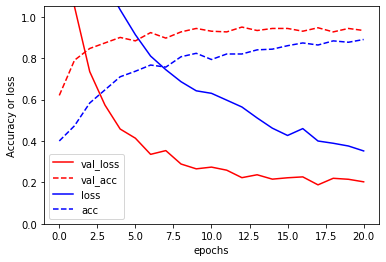

epoch=21: 

100%|██████████| 319/319 [00:45<00:00,  6.95it/s, loss=0.319, val_loss=0.193, acc=0.893, val_acc=0.94]


epoch=22: 

100%|██████████| 319/319 [00:45<00:00,  7.02it/s, loss=0.341, val_loss=0.188, acc=0.893, val_acc=0.947]


epoch=23: 

100%|██████████| 319/319 [00:45<00:00,  6.94it/s, loss=0.307, val_loss=0.179, acc=0.91, val_acc=0.937]


epoch=24: 

100%|██████████| 319/319 [00:45<00:00,  6.98it/s, loss=0.297, val_loss=0.2, acc=0.923, val_acc=0.94]


epoch=25: 

100%|██████████| 319/319 [00:45<00:00,  7.03it/s, loss=0.264, val_loss=0.186, acc=0.917, val_acc=0.957]


epoch=26: 

100%|██████████| 319/319 [00:46<00:00,  6.93it/s, loss=0.259, val_loss=0.19, acc=0.93, val_acc=0.943]


epoch=27: 

100%|██████████| 319/319 [00:46<00:00,  6.84it/s, loss=0.261, val_loss=0.18, acc=0.93, val_acc=0.947]


epoch=28: 

100%|██████████| 319/319 [00:46<00:00,  6.81it/s, loss=0.255, val_loss=0.196, acc=0.927, val_acc=0.957]


epoch=29: 

100%|██████████| 319/319 [00:46<00:00,  6.93it/s, loss=0.258, val_loss=0.192, acc=0.93, val_acc=0.943]


accuracy=0.9156862745098039


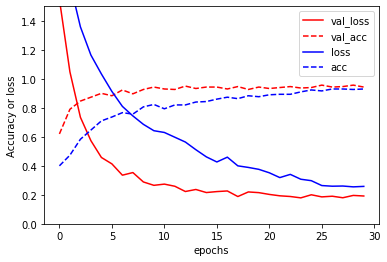

[I 2022-08-23 14:37:38,762] Trial 3 finished with value: 0.2580597534494712 and parameters: {'bs': 16, 'fs': 16, 'wdl': 3.871546576009465e-05}. Best is trial 0 with value: 0.07748191759823211.


24
24
2.9935068478276994e-05
(5100, 1, 28, 28)
(5100, 15)
epoch=0: 

100%|██████████| 213/213 [01:04<00:00,  3.33it/s, loss=1.68, val_loss=1.29, acc=0.513, val_acc=0.747]


epoch=1: 

100%|██████████| 213/213 [01:03<00:00,  3.35it/s, loss=1.2, val_loss=0.753, acc=0.67, val_acc=0.873]


epoch=2: 

100%|██████████| 213/213 [01:04<00:00,  3.30it/s, loss=0.975, val_loss=0.498, acc=0.69, val_acc=0.913]


epoch=3: 

100%|██████████| 213/213 [01:03<00:00,  3.34it/s, loss=0.79, val_loss=0.391, acc=0.737, val_acc=0.93]


epoch=4: 

100%|██████████| 213/213 [01:03<00:00,  3.35it/s, loss=0.715, val_loss=0.336, acc=0.757, val_acc=0.93]


epoch=5: 

100%|██████████| 213/213 [01:03<00:00,  3.37it/s, loss=0.661, val_loss=0.307, acc=0.77, val_acc=0.943]


epoch=6: 

100%|██████████| 213/213 [01:03<00:00,  3.37it/s, loss=0.61, val_loss=0.298, acc=0.793, val_acc=0.93]


epoch=7: 

100%|██████████| 213/213 [01:04<00:00,  3.32it/s, loss=0.516, val_loss=0.237, acc=0.837, val_acc=0.963]


epoch=8: 

100%|██████████| 213/213 [01:03<00:00,  3.35it/s, loss=0.472, val_loss=0.214, acc=0.84, val_acc=0.957]


epoch=9: 

100%|██████████| 213/213 [01:03<00:00,  3.36it/s, loss=0.48, val_loss=0.247, acc=0.837, val_acc=0.947]


epoch=10: 

100%|██████████| 213/213 [01:03<00:00,  3.36it/s, loss=0.476, val_loss=0.24, acc=0.83, val_acc=0.933]


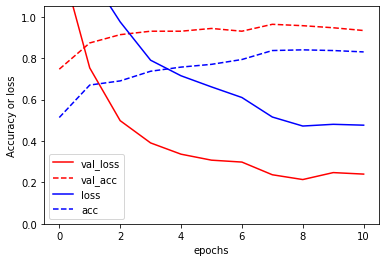

epoch=11: 

100%|██████████| 213/213 [01:04<00:00,  3.30it/s, loss=0.41, val_loss=0.221, acc=0.867, val_acc=0.937]


epoch=12: 

100%|██████████| 213/213 [01:04<00:00,  3.30it/s, loss=0.371, val_loss=0.193, acc=0.863, val_acc=0.943]


epoch=13: 

100%|██████████| 213/213 [01:03<00:00,  3.33it/s, loss=0.354, val_loss=0.165, acc=0.887, val_acc=0.97]


epoch=14: 

100%|██████████| 213/213 [01:02<00:00,  3.39it/s, loss=0.331, val_loss=0.165, acc=0.89, val_acc=0.96]


epoch=15: 

100%|██████████| 213/213 [01:03<00:00,  3.38it/s, loss=0.344, val_loss=0.176, acc=0.89, val_acc=0.967]


epoch=16: 

100%|██████████| 213/213 [01:02<00:00,  3.40it/s, loss=0.292, val_loss=0.168, acc=0.887, val_acc=0.963]


epoch=17: 

100%|██████████| 213/213 [01:03<00:00,  3.36it/s, loss=0.287, val_loss=0.157, acc=0.897, val_acc=0.967]


epoch=18: 

100%|██████████| 213/213 [01:02<00:00,  3.39it/s, loss=0.26, val_loss=0.161, acc=0.91, val_acc=0.953]


epoch=19: 

100%|██████████| 213/213 [01:02<00:00,  3.41it/s, loss=0.247, val_loss=0.138, acc=0.917, val_acc=0.973]


epoch=20: 

100%|██████████| 213/213 [01:02<00:00,  3.39it/s, loss=0.218, val_loss=0.134, acc=0.95, val_acc=0.97]


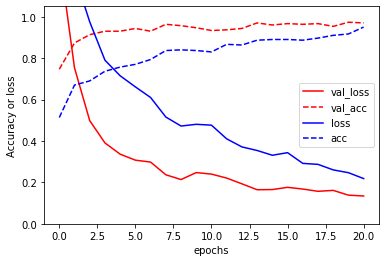

epoch=21: 

100%|██████████| 213/213 [01:03<00:00,  3.35it/s, loss=0.224, val_loss=0.148, acc=0.933, val_acc=0.96]


epoch=22: 

100%|██████████| 213/213 [01:04<00:00,  3.32it/s, loss=0.212, val_loss=0.137, acc=0.92, val_acc=0.973]


epoch=23: 

100%|██████████| 213/213 [01:03<00:00,  3.35it/s, loss=0.207, val_loss=0.143, acc=0.937, val_acc=0.963]


epoch=24: 

100%|██████████| 213/213 [01:03<00:00,  3.36it/s, loss=0.218, val_loss=0.145, acc=0.923, val_acc=0.967]


epoch=25: 

100%|██████████| 213/213 [01:02<00:00,  3.39it/s, loss=0.201, val_loss=0.138, acc=0.93, val_acc=0.983]


epoch=26: 

100%|██████████| 213/213 [01:02<00:00,  3.39it/s, loss=0.175, val_loss=0.138, acc=0.943, val_acc=0.967]


epoch=27: 

100%|██████████| 213/213 [01:04<00:00,  3.29it/s, loss=0.173, val_loss=0.138, acc=0.95, val_acc=0.973]


epoch=28: 

100%|██████████| 213/213 [01:04<00:00,  3.31it/s, loss=0.166, val_loss=0.143, acc=0.947, val_acc=0.973]


epoch=29: 

100%|██████████| 213/213 [01:03<00:00,  3.36it/s, loss=0.163, val_loss=0.133, acc=0.947, val_acc=0.963]


accuracy=0.9454901960784313


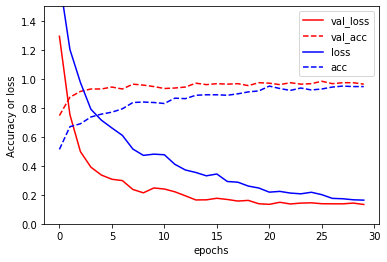

[I 2022-08-23 15:09:48,438] Trial 4 finished with value: 0.16316715073646076 and parameters: {'bs': 24, 'fs': 24, 'wdl': 2.9935068478276994e-05}. Best is trial 0 with value: 0.07748191759823211.


In [13]:
def objective(trial):
    epochs = 30
    batch_size = trial.suggest_int('bs',8,24,step=8)
    fs = trial.suggest_int('fs',16,32,step=8)
    wdl=trial.suggest_loguniform('wdl',5e-6,5e-5)
    num=2
    print(batch_size)
    print(fs)
    print(wdl)
  #モデルを作成
    x,t=create_img(X_train,y_train,num)
    model = build_model(fs,wdl)
    history = model.fit(model,x,t,epochs,batch_size,X_test,y_test)
    train_acc =model.accuracy(x,t)
    print('accuracy={}'.format(train_acc))
    # lossとaccuracyのグラフ化
    df_log = pd.DataFrame(history)
    df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
    plt.ylim([0,1.5])
    plt.ylabel("Accuracy or loss")
    plt.xlabel("epochs")
    plt.show()

    #検証用データに対する正答率が最大となるハイパーパラメータを求める
    return history['loss'][-1]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

In [23]:
from operator import itemgetter
bs,fs,wdl=itemgetter('bs', 'fs','wdl')(study.best_params)
print(study.best_params)
print(bs)

{'bs': 8, 'fs': 32, 'wdl': 7.894265773019396e-06}
8


(5100, 1, 28, 28)
(5100, 15)
epoch=0: 

100%|██████████| 638/638 [01:40<00:00,  6.36it/s, loss=1.38, val_loss=0.842, acc=0.58, val_acc=0.773]


epoch=1: 

100%|██████████| 638/638 [01:39<00:00,  6.41it/s, loss=0.949, val_loss=0.474, acc=0.7, val_acc=0.857]


epoch=2: 

100%|██████████| 638/638 [01:37<00:00,  6.57it/s, loss=0.718, val_loss=0.297, acc=0.737, val_acc=0.903]


epoch=3: 

100%|██████████| 638/638 [01:39<00:00,  6.38it/s, loss=0.627, val_loss=0.242, acc=0.8, val_acc=0.93]


epoch=4: 

100%|██████████| 638/638 [01:40<00:00,  6.35it/s, loss=0.595, val_loss=0.203, acc=0.797, val_acc=0.953]


epoch=5: 

100%|██████████| 638/638 [01:39<00:00,  6.42it/s, loss=0.499, val_loss=0.209, acc=0.83, val_acc=0.933]


epoch=6: 

100%|██████████| 638/638 [01:38<00:00,  6.50it/s, loss=0.451, val_loss=0.202, acc=0.83, val_acc=0.927]


epoch=7: 

100%|██████████| 638/638 [01:35<00:00,  6.65it/s, loss=0.408, val_loss=0.157, acc=0.877, val_acc=0.957]


epoch=8: 

100%|██████████| 638/638 [01:37<00:00,  6.52it/s, loss=0.354, val_loss=0.19, acc=0.877, val_acc=0.947]


epoch=9: 

100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.383, val_loss=0.163, acc=0.867, val_acc=0.943]


epoch=10: 

100%|██████████| 638/638 [01:36<00:00,  6.60it/s, loss=0.298, val_loss=0.168, acc=0.91, val_acc=0.937]


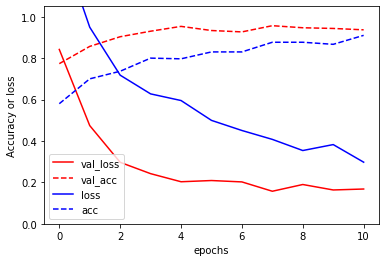

epoch=11: 

100%|██████████| 638/638 [01:37<00:00,  6.52it/s, loss=0.239, val_loss=0.148, acc=0.917, val_acc=0.947]


epoch=12: 

100%|██████████| 638/638 [01:36<00:00,  6.63it/s, loss=0.284, val_loss=0.161, acc=0.91, val_acc=0.96]


epoch=13: 

100%|██████████| 638/638 [01:36<00:00,  6.64it/s, loss=0.255, val_loss=0.13, acc=0.897, val_acc=0.96]


epoch=14: 

100%|██████████| 638/638 [01:37<00:00,  6.54it/s, loss=0.228, val_loss=0.118, acc=0.917, val_acc=0.97]


epoch=15: 

100%|██████████| 638/638 [01:35<00:00,  6.67it/s, loss=0.206, val_loss=0.148, acc=0.917, val_acc=0.943]


epoch=16: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.206, val_loss=0.176, acc=0.92, val_acc=0.957]


epoch=17: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.193, val_loss=0.127, acc=0.947, val_acc=0.96]


epoch=18: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.206, val_loss=0.134, acc=0.933, val_acc=0.97]


epoch=19: 

100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.164, val_loss=0.114, acc=0.95, val_acc=0.973]


epoch=20: 

100%|██████████| 638/638 [01:36<00:00,  6.61it/s, loss=0.154, val_loss=0.148, acc=0.94, val_acc=0.957]


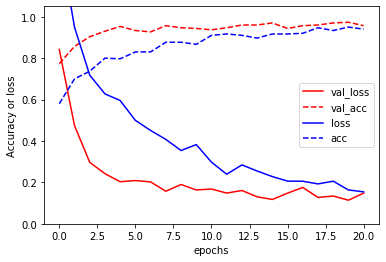

epoch=21: 

100%|██████████| 638/638 [01:33<00:00,  6.83it/s, loss=0.142, val_loss=0.148, acc=0.957, val_acc=0.963]


epoch=22: 

100%|██████████| 638/638 [01:34<00:00,  6.77it/s, loss=0.146, val_loss=0.144, acc=0.96, val_acc=0.963]


epoch=23: 

100%|██████████| 638/638 [01:35<00:00,  6.70it/s, loss=0.12, val_loss=0.148, acc=0.963, val_acc=0.963]


epoch=24: 

100%|██████████| 638/638 [01:34<00:00,  6.78it/s, loss=0.12, val_loss=0.137, acc=0.967, val_acc=0.973]


epoch=25: 

100%|██████████| 638/638 [01:35<00:00,  6.70it/s, loss=0.115, val_loss=0.114, acc=0.97, val_acc=0.97]


epoch=26: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.104, val_loss=0.154, acc=0.967, val_acc=0.96]


epoch=27: 

100%|██████████| 638/638 [01:35<00:00,  6.71it/s, loss=0.107, val_loss=0.15, acc=0.963, val_acc=0.957]


epoch=28: 

100%|██████████| 638/638 [01:34<00:00,  6.72it/s, loss=0.108, val_loss=0.145, acc=0.98, val_acc=0.963]


epoch=29: 

100%|██████████| 638/638 [01:34<00:00,  6.79it/s, loss=0.0919, val_loss=0.165, acc=0.983, val_acc=0.967]


epoch=30: 

100%|██████████| 638/638 [01:35<00:00,  6.67it/s, loss=0.0854, val_loss=0.134, acc=0.973, val_acc=0.963]


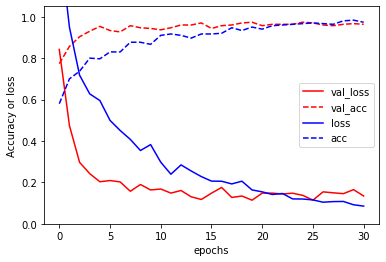

epoch=31: 

100%|██████████| 638/638 [01:34<00:00,  6.73it/s, loss=0.104, val_loss=0.178, acc=0.96, val_acc=0.967]


epoch=32: 

100%|██████████| 638/638 [01:33<00:00,  6.82it/s, loss=0.0889, val_loss=0.13, acc=0.99, val_acc=0.973]


epoch=33: 

100%|██████████| 638/638 [01:33<00:00,  6.83it/s, loss=0.0829, val_loss=0.167, acc=0.98, val_acc=0.967]


epoch=34: 

100%|██████████| 638/638 [01:34<00:00,  6.74it/s, loss=0.0807, val_loss=0.14, acc=0.983, val_acc=0.973]


epoch=35: 

100%|██████████| 638/638 [01:34<00:00,  6.76it/s, loss=0.0857, val_loss=0.139, acc=0.987, val_acc=0.967]


epoch=36: 

100%|██████████| 638/638 [01:33<00:00,  6.84it/s, loss=0.0758, val_loss=0.146, acc=0.993, val_acc=0.97]


epoch=37: 

100%|██████████| 638/638 [01:35<00:00,  6.69it/s, loss=0.0823, val_loss=0.156, acc=0.983, val_acc=0.967]


epoch=38: 

100%|██████████| 638/638 [01:31<00:00,  6.96it/s, loss=0.0848, val_loss=0.139, acc=0.987, val_acc=0.973]


epoch=39: 

100%|██████████| 638/638 [01:30<00:00,  7.04it/s, loss=0.0811, val_loss=0.131, acc=0.993, val_acc=0.97]


epoch=40: 

100%|██████████| 638/638 [01:32<00:00,  6.92it/s, loss=0.0935, val_loss=0.164, acc=0.99, val_acc=0.967]


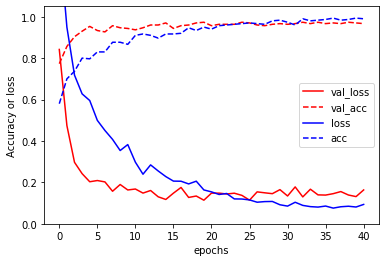

epoch=41: 

100%|██████████| 638/638 [01:33<00:00,  6.84it/s, loss=0.0749, val_loss=0.154, acc=0.993, val_acc=0.977]


epoch=42: 

100%|██████████| 638/638 [01:31<00:00,  6.96it/s, loss=0.0795, val_loss=0.153, acc=0.99, val_acc=0.97]


epoch=43: 

100%|██████████| 638/638 [01:32<00:00,  6.88it/s, loss=0.0774, val_loss=0.172, acc=0.993, val_acc=0.967]


epoch=44: 

100%|██████████| 638/638 [01:32<00:00,  6.89it/s, loss=0.0717, val_loss=0.155, acc=0.997, val_acc=0.973]


epoch=45: 

100%|██████████| 638/638 [01:32<00:00,  6.89it/s, loss=0.0887, val_loss=0.171, acc=0.993, val_acc=0.963]


epoch=46: 

100%|██████████| 638/638 [01:34<00:00,  6.78it/s, loss=0.0961, val_loss=0.166, acc=0.987, val_acc=0.98]


epoch=47: 

100%|██████████| 638/638 [01:32<00:00,  6.86it/s, loss=0.0776, val_loss=0.19, acc=0.987, val_acc=0.97]


epoch=48: 

100%|██████████| 638/638 [01:32<00:00,  6.89it/s, loss=0.0813, val_loss=0.182, acc=0.997, val_acc=0.967]


epoch=49: 

100%|██████████| 638/638 [01:34<00:00,  6.76it/s, loss=0.0775, val_loss=0.152, acc=1, val_acc=0.97]


epoch=50: 

100%|██████████| 638/638 [02:05<00:00,  5.09it/s, loss=0.0112, val_loss=0.119, acc=1, val_acc=0.97]


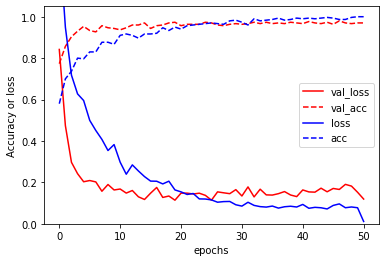

epoch=51: 

100%|██████████| 638/638 [01:36<00:00,  6.64it/s, loss=0.00843, val_loss=0.117, acc=1, val_acc=0.97]


epoch=52: 

100%|██████████| 638/638 [01:34<00:00,  6.77it/s, loss=0.00847, val_loss=0.117, acc=1, val_acc=0.97]


epoch=53: 

100%|██████████| 638/638 [01:36<00:00,  6.59it/s, loss=0.00852, val_loss=0.117, acc=1, val_acc=0.97]


epoch=54: 

100%|██████████| 638/638 [01:34<00:00,  6.73it/s, loss=0.00858, val_loss=0.117, acc=1, val_acc=0.97]


epoch=55: 

100%|██████████| 638/638 [01:34<00:00,  6.77it/s, loss=0.00866, val_loss=0.117, acc=1, val_acc=0.97]


epoch=56: 

100%|██████████| 638/638 [01:36<00:00,  6.61it/s, loss=0.00877, val_loss=0.118, acc=1, val_acc=0.97]


epoch=57: 

100%|██████████| 638/638 [01:34<00:00,  6.78it/s, loss=0.00889, val_loss=0.118, acc=1, val_acc=0.97]


epoch=58: 

100%|██████████| 638/638 [01:34<00:00,  6.75it/s, loss=0.00902, val_loss=0.118, acc=1, val_acc=0.97]


epoch=59: 

100%|██████████| 638/638 [01:33<00:00,  6.79it/s, loss=0.00917, val_loss=0.118, acc=1, val_acc=0.97]


epoch=60: 

100%|██████████| 638/638 [01:35<00:00,  6.69it/s, loss=0.00935, val_loss=0.118, acc=1, val_acc=0.97]


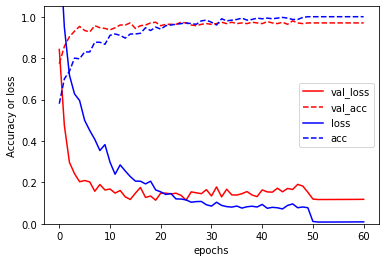

epoch=61: 

100%|██████████| 638/638 [01:34<00:00,  6.77it/s, loss=0.00955, val_loss=0.118, acc=1, val_acc=0.97]


epoch=62: 

100%|██████████| 638/638 [01:34<00:00,  6.78it/s, loss=0.00976, val_loss=0.119, acc=1, val_acc=0.97]


epoch=63: 

100%|██████████| 638/638 [01:34<00:00,  6.77it/s, loss=0.00998, val_loss=0.119, acc=1, val_acc=0.97]


epoch=64: 

100%|██████████| 638/638 [01:33<00:00,  6.81it/s, loss=0.0102, val_loss=0.119, acc=1, val_acc=0.97]


epoch=65: 

100%|██████████| 638/638 [01:33<00:00,  6.82it/s, loss=0.0105, val_loss=0.119, acc=1, val_acc=0.97]


epoch=66: 

100%|██████████| 638/638 [01:34<00:00,  6.78it/s, loss=0.0108, val_loss=0.12, acc=1, val_acc=0.97]


epoch=67: 

100%|██████████| 638/638 [01:32<00:00,  6.89it/s, loss=0.0111, val_loss=0.12, acc=1, val_acc=0.97]


epoch=68: 

100%|██████████| 638/638 [01:32<00:00,  6.89it/s, loss=0.0114, val_loss=0.12, acc=1, val_acc=0.97]


epoch=69: 

100%|██████████| 638/638 [01:33<00:00,  6.80it/s, loss=0.0117, val_loss=0.121, acc=1, val_acc=0.97]


epoch=70: 

100%|██████████| 638/638 [01:34<00:00,  6.79it/s, loss=0.0121, val_loss=0.121, acc=1, val_acc=0.97]


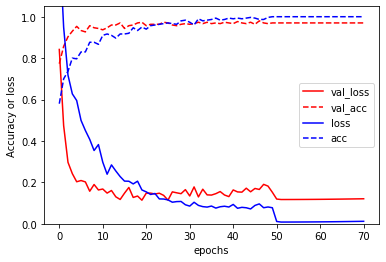

epoch=71: 

100%|██████████| 638/638 [01:35<00:00,  6.69it/s, loss=0.0124, val_loss=0.121, acc=1, val_acc=0.97]


epoch=72: 

100%|██████████| 638/638 [01:34<00:00,  6.78it/s, loss=0.0128, val_loss=0.122, acc=1, val_acc=0.97]


epoch=73: 

100%|██████████| 638/638 [01:33<00:00,  6.80it/s, loss=0.0132, val_loss=0.122, acc=1, val_acc=0.97]


epoch=74: 

100%|██████████| 638/638 [01:34<00:00,  6.77it/s, loss=0.0136, val_loss=0.122, acc=1, val_acc=0.97]


epoch=75: 

100%|██████████| 638/638 [01:34<00:00,  6.75it/s, loss=0.014, val_loss=0.123, acc=1, val_acc=0.97]


epoch=76: 

100%|██████████| 638/638 [01:33<00:00,  6.84it/s, loss=0.0145, val_loss=0.123, acc=1, val_acc=0.97]


epoch=77: 

100%|██████████| 638/638 [01:33<00:00,  6.84it/s, loss=0.015, val_loss=0.124, acc=1, val_acc=0.97]


epoch=78: 

100%|██████████| 638/638 [01:34<00:00,  6.76it/s, loss=0.0155, val_loss=0.124, acc=1, val_acc=0.97]


epoch=79: 

100%|██████████| 638/638 [01:33<00:00,  6.84it/s, loss=0.016, val_loss=0.125, acc=1, val_acc=0.97]


epoch=80: 

100%|██████████| 638/638 [02:06<00:00,  5.03it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


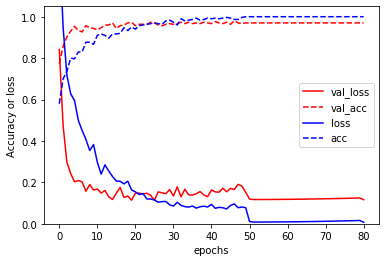

epoch=81: 

100%|██████████| 638/638 [01:33<00:00,  6.79it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=82: 

100%|██████████| 638/638 [01:34<00:00,  6.74it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=83: 

100%|██████████| 638/638 [01:35<00:00,  6.70it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=84: 

100%|██████████| 638/638 [01:34<00:00,  6.72it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=85: 

100%|██████████| 638/638 [01:33<00:00,  6.82it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=86: 

100%|██████████| 638/638 [01:33<00:00,  6.80it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=87: 

100%|██████████| 638/638 [01:33<00:00,  6.80it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=88: 

100%|██████████| 638/638 [01:34<00:00,  6.75it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=89: 

100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=90: 

100%|██████████| 638/638 [01:33<00:00,  6.79it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


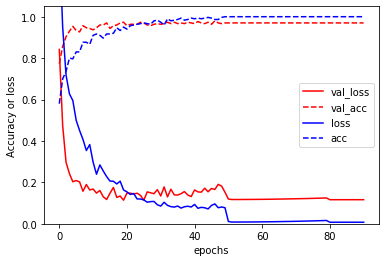

epoch=91: 

100%|██████████| 638/638 [01:33<00:00,  6.79it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=92: 

100%|██████████| 638/638 [01:34<00:00,  6.77it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=93: 

100%|██████████| 638/638 [01:33<00:00,  6.84it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=94: 

100%|██████████| 638/638 [01:33<00:00,  6.82it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=95: 

100%|██████████| 638/638 [01:33<00:00,  6.85it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=96: 

100%|██████████| 638/638 [01:33<00:00,  6.85it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=97: 

100%|██████████| 638/638 [01:33<00:00,  6.86it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=98: 

100%|██████████| 638/638 [01:33<00:00,  6.84it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


epoch=99: 

100%|██████████| 638/638 [01:33<00:00,  6.83it/s, loss=0.00757, val_loss=0.116, acc=1, val_acc=0.97]


accuracy=0.9488888888888889


In [24]:
epochs = 100

num=2
x,t=create_img(X_train,y_train,num)
model = build_model(fs,wdl)
history =  model.fit(model,x,t,epochs,bs,X_test,y_test)
test_acc =model.accuracy(X_test,y_test)
print('accuracy={}'.format(test_acc))